In [1]:
import sys, os

sys.path.append('../lib/')
sys.path.append('../sim_lib/')

def ospath(paths):
    if ('win32' in sys.platform):
        if type(paths)==list or type(paths)==tuple:
            paths = [fn.replace('/c/','c:\\').replace('/', '\\') for fn in paths]
        else:
            paths = paths.replace('/c/','c:\\').replace('/', '\\')
    return paths

import numpy as np

import logging
logger = logging.getLogger('stochastic_ir')
hdlr = logging.FileHandler('./stochastic_ir.log')
formatter = logging.Formatter('%(asctime)s %(levelname)s %(message)s')
hdlr.setFormatter(formatter)
logger.addHandler(hdlr) 
logger.setLevel(logging.INFO)

from  matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter

import datetime
import copy
import pickle

In [2]:
from scipy.stats import norm
import scipy.optimize as opt
import scipy.integrate as integrate
from scipy.integrate import simps
from scipy.integrate import cumtrapz
import scipy.interpolate

In [3]:
import json
import calibrator
import interpolator
import surfaces

# Read Implied Vol, correlations, EUR and USD DF curves

In [4]:
MARKETDATA = '../marketdata_JSON_asof_04_30_2020/'
with open(MARKETDATA+'EUR.json', 'r') as f:
    eurdata = json.load(f)
with open(MARKETDATA+'USD.json', 'r') as f:
    usddata = json.load(f)
with open(MARKETDATA+'EURUSD.json', 'r') as f:
    eurusddata = json.load(f)
with open(MARKETDATA+'correlations.json', 'r') as f:
    correlations = json.load(f)

In [5]:
with open(MARKETDATA+'EURUSD_Heston.json', 'r') as f:
    hestondata = json.load(f)
    
heston_kappa_dict = hestondata['kappa'] 
heston_volofvar_dict = hestondata['volofvar'] 
heston_theta_dict = hestondata['theta'] 
heston_initialvar = hestondata['initialvar']

In [6]:
rho_domestic_base = correlations['USD_EUR']
rho_base_fx = correlations['EUR_EURUSD']
rho_domestic_fx = correlations['USD_EURUSD']

base_ta = eurdata['g1++']['meanrev']['times']
base_a = eurdata['g1++']['meanrev']['values']
base_tvol = eurdata['g1++']['vol']['times']
base_vol = eurdata['g1++']['vol']['values']
base_x0 = eurdata['g1++']['x0']
base_shifttimes = eurdata['g1++']['shift']['times']
base_shiftvalues = eurdata['g1++']['shift']['values']

domestic_ta = usddata['g1++']['meanrev']['times']
domestic_a = usddata['g1++']['meanrev']['values']
domestic_tvol = usddata['g1++']['vol']['times']
domestic_vol = usddata['g1++']['vol']['values']
domestic_x0 = usddata['g1++']['x0']
domestic_shifttimes = usddata['g1++']['shift']['times']
domestic_shiftvalues = usddata['g1++']['shift']['values']

fxvoldata = eurusddata['impliedvol']
spot_FX = eurusddata['spot']

base_dfcurve = interpolator.InterpolatedCurve(eurdata['discount']['times'], 
                                              eurdata['discount']['values'])
dfcurve = interpolator.InterpolatedCurve(usddata['discount']['times'], 
                                         usddata['discount']['values'])

rho_fx_v = hestondata['rho'] 
rho_domestic_v = correlations['USD_EURUSDstochvar']
rho_base_v = correlations['EUR_EURUSDstochvar']

# Simulator

In [7]:
import StochasticSim_Multiprocessing as simulator

In [8]:
if 'locvol_sim' in locals() or 'locvol_sim' in globals():
    locvol_sim.delete_all()
    del(locvol_sim)
    print('Deleted lvolsim')

In [9]:
domestic_shortratecrv = interpolator.constructShortRateCurve(dfcurve)
base_shortratecrv = interpolator.constructShortRateCurve(base_dfcurve)

In [10]:
nr_mcruns = 100000 ### number of calibration runs
NRSUBSIM = 5  ### number of multiprocessing sub-processes 
LVOL_NUMMETHOD = 'ForwardEuler'
SHORTRATE_NUMMETHOD = 'ForwardEuler'
ANTITHETIC = True

locvol_sim = simulator.StochasticLocalVolSimulation(
                domestic_shortratecrv.times, domestic_shortratecrv.values, 
                base_shortratecrv.times, base_shortratecrv.values, spot_FX,
                heston_initialvar, heston_volofvar_dict, 
                heston_kappa_dict, heston_theta_dict,
                domestic_ta, domestic_a, domestic_tvol, domestic_vol, domestic_x0,
                base_ta, base_a, base_tvol, base_vol, base_x0,
                rho_domestic_base, rho_domestic_fx, rho_base_fx,
                rho_fx_v, rho_domestic_v, rho_base_v,
                nr_mcruns, LVOL_NUMMETHOD, SHORTRATE_NUMMETHOD,
                antitheticpaths=ANTITHETIC,
                in_forward_measure=False,
                nrsubsim=NRSUBSIM,
                observation_names=['FXrate', 'FXStochVariance'],
                observe_at_given_times=True,
                domestic_currency_name='USD',
                base_currency_name='EUR',
                fx_name='EURUSD',
                )

Allocating shmem ...HESTON UT 
Allocating shmem ...HESTON UT 
Allocating shmem ...HESTON UT 
Allocating shmem ...HESTON UT 
Allocating shmem ...HESTON UT 
Allocating shmem ...XS RD RB 
Allocating shmem ...XS RD RB 
Allocating shmem ...XS RD RB 
Allocating shmem ...XS RD RB 
Allocating shmem ...XS RD RB 
Initializing pool for ... <class 'StochasticSim_Multiprocessing.StochasticLocalVolSimulation'>


# Read the leverage function

In [11]:
LVOL_PATH = './output_SLV_2DIR/'
L_FILENAME = 'leverage_sampleFULL_100000.pkl'

with open(LVOL_PATH + L_FILENAME, 'rb') as f:
    l_data = pickle.load(f)
l_strikes = l_data['spots']
l_times = l_data['times']
l_values = l_data['surfacevalues']

strikes_all = l_data['spots'][1:]
tslices = l_data['times'][1:]
lvol_all = l_data['surfacevalues'][1:]

In [12]:
OPTION_EXPIRY = 1.0 #l_times[-1]
locvol_sim.update_localvol(l_data['spots'], l_data['times'], l_data['surfacevalues'])
locvol_sim.update_domestic_bfactors(OPTION_EXPIRY)
locvol_sim.update_base_bfactors(OPTION_EXPIRY)

1.0 250


In [13]:
locvol_sim.run()

ProcessID:0, n_trials:20000, maturity:1.000, timesteps:250
ProcessID:1, n_trials:20000, maturity:1.000, timesteps:250
ProcessID:2, n_trials:20000, maturity:1.000, timesteps:250
ProcessID:3, n_trials:20000, maturity:1.000, timesteps:250
ProcessID:4, n_trials:20000, maturity:1.000, timesteps:250


# Collect results

In [14]:
n_timesteps = locvol_sim.tdisargs['time_steps']
n_trials_per_process = locvol_sim.n_paths_per_process
tdisargs = locvol_sim.tdisargs['time_steps']
dtype_glob = locvol_sim.dtype_glob

In [15]:
Xsamples = np.concatenate([np.frombuffer(xs, dtype=dtype_glob)
                           .reshape((n_trials_per_process, -1))[:,:n_timesteps+1] 
                           for xs in locvol_sim.Xsamples_raw], axis=0)
tstamps = np.concatenate([np.frombuffer(ts, dtype=dtype_glob)
                          .reshape((1, -1))[:,:n_timesteps] 
                          for ts in locvol_sim.t_stamp_raw], axis=0) 

(20, 100) (20, 100) (20, 100)


Text(0.5, 0.92, 'Leverage surface')

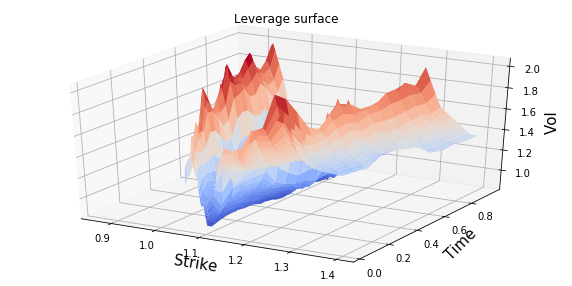

In [16]:
fig = plt.figure(figsize=(10,5))
plotid=1
num_slices=20
X_lvol = np.array(strikes_all[:num_slices]) 
Y_lvol = np.array([tslices[:num_slices]]*X_lvol.shape[1]).T
Z_lvol = np.array(lvol_all[:num_slices])
print(X_lvol.shape, Y_lvol.shape, Z_lvol.shape)

ax = fig.add_subplot(1, 1, plotid, projection='3d') #fig.add_subplot(2, 2, plotid, projection='3d')
surf = ax.plot_surface(X_lvol, Y_lvol, Z_lvol, cmap=cm.coolwarm, linewidth=1, antialiased=True)
ax.set_zlabel('Vol', fontsize=15, rotation = 90)
ax.set_ylabel('Time', fontsize=15, rotation = 45)
ax.set_xlabel('Strike', fontsize=15, rotation = 0)
#ax.set_zlim([-0.05, 0.13])
ax.set_title('Leverage surface')

# Interpolate Implied Vol

In [17]:
import fxivolinterpolator as fxvol

In [18]:
fxvolsurf = fxvol.FXIVolInterpolator(eurusddata['impliedvol'], eurusddata['spot'], dfcurve, base_dfcurve)

# Analytical Surface For Comparison

In [19]:
import bsanalytic as bsan

In [20]:
callsurf_all = []
for tval,strikevals in zip(tslices, strikes_all):
    reff = -np.log(dfcurve(tval))/tval
    qeff = -np.log(base_dfcurve(tval))/tval
    print('t=%.3f'%tval)
    ivol_ref = np.array([fxvolsurf.impliedvol_K(tval, K) for K in strikevals])
    callprices = bsan.Call(spot_FX, np.array(strikevals), tval, reff, qeff, ivol_ref)
    callsurf_all.append(callprices)

t=0.025
t=0.050
t=0.100
t=0.150
t=0.200
t=0.250
t=0.300
t=0.350
t=0.400
t=0.450
t=0.500
t=0.550
t=0.600
t=0.650
t=0.700
t=0.750
t=0.800
t=0.850
t=0.900
t=0.950


(19, 100) (19, 100) (19, 100)


Text(0.5, 0.92, 'Call Surface')

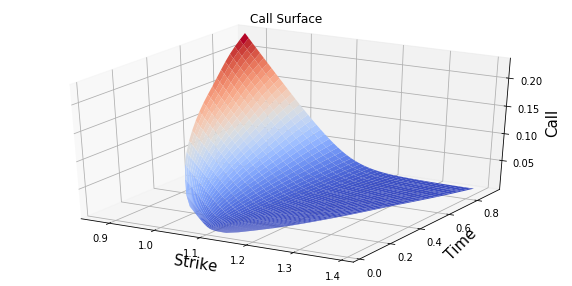

In [21]:
fig = plt.figure(figsize=(10,5))
plotid=1
num_slices=-1
X_Callsurf = np.array(strikes_all[:num_slices])
Y_Callsurf = np.array([tslices[:num_slices]]*X_Callsurf.shape[1]).T
Z_Callsurf = np.array(callsurf_all[:num_slices])
print(X_Callsurf.shape, Y_Callsurf.shape, Z_Callsurf.shape)

ax = fig.add_subplot(1, 1, plotid, projection='3d') #fig.add_subplot(2, 2, plotid, projection='3d')
surf = ax.plot_surface(X_Callsurf, Y_Callsurf, Z_Callsurf, cmap=cm.coolwarm, linewidth=1, antialiased=True)
ax.set_zlabel('Call', fontsize=15, rotation = 90)
ax.set_ylabel('Time', fontsize=15, rotation = 45)
ax.set_xlabel('Strike', fontsize=15, rotation = 0)
#ax.set_zlim([0.05, 0.13])
ax.set_title('Call Surface')
#ax.view_init(20, 240)

# MC Call Surface

In [22]:
#Call price Simulator
t_stamp = tstamps[0]
Values_call = []
StdErr_call = []
Values_put = []
StdErr_put = []
Strikes_finaldict = []
finaldict={}
finaldict['MCMean'] = {}
finaldict['MCStdErr'] = {}
def calc_mc(X, K, df, option_type='call'):
    mcval = np.maximum(X-K, 0)*df if option_type.lower()=='call' else np.maximum(K-X, 0)*df 
    mcmean = np.mean(mcval)
    mcerr = np.std(mcval-mcmean)/np.sqrt(X.shape[0])
    return mcmean, mcerr

from itertools import compress

for tidx, t in enumerate(list(compress(tslices, tslices<t_stamp[-1]))): #[:num_slices]):
    idx = np.searchsorted(t_stamp, t) # max(0, np.searchsorted(t_stamp, t)-1)
    strikes = strikes_all[tidx]
    domestic_df = dfcurve(t)
    print('t=%.3f, idx=%d'%(t, idx))
    MCMean_call, MCErr_call = zip(*[calc_mc(Xsamples[:,idx], K, domestic_df, option_type='call') for K in strikes])
    MCMean_put, MCErr_put = zip(*[calc_mc(Xsamples[:,idx], K, domestic_df, option_type='put') for K in strikes])
    Values_call.append(list(MCMean_call))
    StdErr_call.append(list(MCErr_call))
    Values_put.append(list(MCMean_put))
    StdErr_put.append(list(MCErr_put))
    Strikes_finaldict.append(strikes)

    
finaldict['Strike'] = Strikes_finaldict #[:num_slices]
finaldict['Expiry'] = list(compress(tslices, tslices<t_stamp[-1])) #tslices[tslices<t_stamp[-1]] #[:num_slices]
finaldict['MCMean']['call'] = Values_call
finaldict['MCStdErr']['call'] = StdErr_call
finaldict['MCMean']['put'] = Values_put
finaldict['MCStdErr']['put'] = StdErr_put

t=0.025, idx=7
t=0.050, idx=13
t=0.100, idx=25
t=0.150, idx=38
t=0.200, idx=50
t=0.250, idx=63
t=0.300, idx=75
t=0.350, idx=88
t=0.400, idx=100
t=0.450, idx=113
t=0.500, idx=125
t=0.550, idx=138
t=0.600, idx=151
t=0.650, idx=163
t=0.700, idx=175
t=0.750, idx=188
t=0.800, idx=200
t=0.850, idx=213
t=0.900, idx=226
t=0.950, idx=238


(20, 100) (20, 100) (20, 100)


Text(0.5, 0.92, 'MC Call Surface')

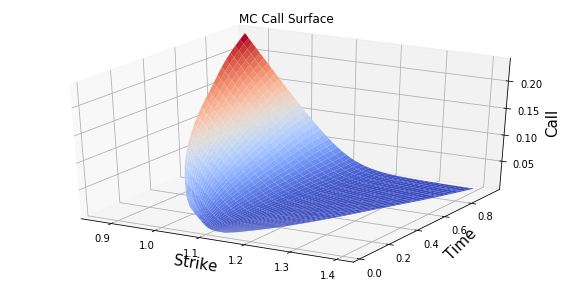

In [23]:
fig = plt.figure(figsize=(10,5))
plotid=1
X_Callsurf = np.array(finaldict['Strike'])
Y_Callsurf = np.array([finaldict['Expiry']]*X_Callsurf.shape[1]).T
Z_Callsurf = np.array(finaldict['MCMean']['call'])
print(X_Callsurf.shape, Y_Callsurf.shape, Z_Callsurf.shape)

ax = fig.add_subplot(1, 1, plotid, projection='3d')  
surf = ax.plot_surface(X_Callsurf, Y_Callsurf, Z_Callsurf, cmap=cm.coolwarm, linewidth=1, antialiased=True)
ax.set_zlabel('Call', fontsize=15, rotation = 90)
ax.set_ylabel('Time', fontsize=15, rotation = 45)
ax.set_xlabel('Strike', fontsize=15, rotation = 0)
#ax.set_zlim([0.05, 0.13])
ax.set_title('MC Call Surface')
#ax.view_init(20, 240)

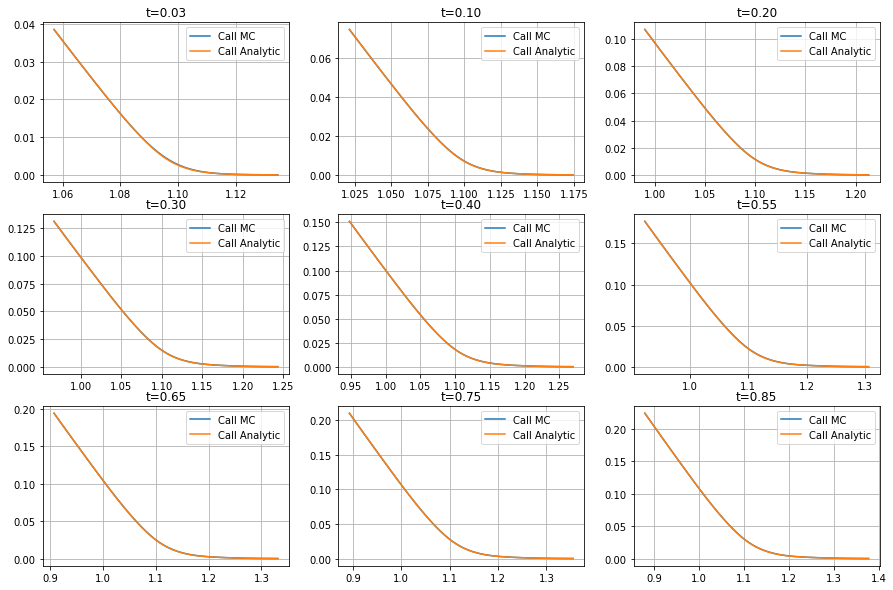

In [24]:
plt.figure(figsize=(15,10))
num_plots = 9
plt.text(10, 10, tdisargs)
for i1 in range(num_plots):
    idxval = int(i1*len(Strikes_finaldict)/num_plots)
    #print(idxval)
    ax = plt.subplot(3,3,i1+1)
    ax.plot(finaldict['Strike'][idxval], finaldict['MCMean']['call'][idxval], label='Call MC')
    ax.plot(finaldict['Strike'][idxval], callsurf_all[idxval], label='Call Analytic')
    ax.legend()
    ax.grid()
    ax.set_title('t=%.2f'%tslices[idxval])

# Comparing implied volatilities at slices

In [25]:
reff_d = [-np.log(dfcurve(t))/t for t in finaldict['Expiry']]
reff_b = [-np.log(base_dfcurve(t))/t for t in finaldict['Expiry']]

In [26]:
ivol_mc = []
ivol_mcup = []
ivol_mcdn = []
ivol_market = []

ivolfunc = lambda S,K,ts,rd, rb, C, P, guess: bsan.impliedvol_call(S,K,ts,rd, rb, C, guess) if S>K else bsan.impliedvol_put(S,K,ts,rd, rb, P, guess)

S = spot_FX
bumpup = 2.0
bumpdn = 2.0
all_call = finaldict['MCMean']['call']
stderr_call = finaldict['MCStdErr']['call']
all_put = finaldict['MCMean']['put']
stderr_put = finaldict['MCStdErr']['put']

for idx,ts in enumerate(finaldict['Expiry']):
    ivol_mc.append([ivolfunc(S, K, ts, reff_d[idx],reff_b[idx], C, P, guess=0.1) for K,C,Ec,P,Ep 
                    in zip(finaldict['Strike'][idx], all_call[idx], stderr_call[idx], all_put[idx], stderr_put[idx])])
    
    ivol_mcup.append([ivolfunc(S, K, ts,reff_d[idx],reff_b[idx],C+bumpup*Ec,P+bumpup*Ep, guess=0.1) for K,C,Ec,P,Ep 
                      in zip(finaldict['Strike'][idx], all_call[idx], stderr_call[idx], all_put[idx], stderr_put[idx])])
    
    ivol_mcdn.append([ivolfunc(S, K, ts,reff_d[idx],reff_b[idx],C-bumpdn*Ec,P-bumpdn*Ep, guess=0.1) for K,C,Ec,P,Ep 
                      in zip(finaldict['Strike'][idx], all_call[idx], stderr_call[idx], all_put[idx], stderr_put[idx])])
    
    ivol_market.append([fxvolsurf.impliedvol_K(ts, K) for K in finaldict['Strike'][idx]])
    
    print('%d, %.3f, %.5f, %.5f, %.5f, %.5f'%(idx,ts, reff_d[idx], reff_b[idx], min(ivol_mc[-1]), max(ivol_mc[-1])))

C:\ProgramData\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


0, 0.025, 0.00043, -0.00571, 0.00337, 0.09409
1, 0.050, 0.00043, -0.00608, 0.06488, 0.09548
2, 0.100, 0.00043, -0.00643, 0.06445, 0.09167
3, 0.150, 0.00044, -0.00672, 0.06497, 0.10150
4, 0.200, 0.00044, -0.00690, 0.06531, 0.10186
5, 0.250, 0.00045, -0.00704, 0.06591, 0.10616
6, 0.300, 0.00045, -0.00718, 0.06586, 0.10644
7, 0.350, 0.00045, -0.00729, 0.06648, 0.10667
8, 0.400, 0.00045, -0.00738, 0.06640, 0.10471
9, 0.450, 0.00045, -0.00742, 0.06689, 0.10531
10, 0.500, 0.00045, -0.00744, 0.06709, 0.10278
11, 0.550, 0.00045, -0.00762, 0.06756, 0.10538
12, 0.600, 0.00044, -0.00785, 0.06794, 0.10737
13, 0.650, 0.00044, -0.00804, 0.06853, 0.10603
14, 0.700, 0.00044, -0.00816, 0.06873, 0.10828
15, 0.750, 0.00044, -0.00818, 0.06920, 0.10893
16, 0.800, 0.00043, -0.00822, 0.06944, 0.10882
17, 0.850, 0.00043, -0.00826, 0.06975, 0.11176
18, 0.900, 0.00043, -0.00830, 0.06986, 0.11443
19, 0.950, 0.00043, -0.00833, 0.06985, 0.11521


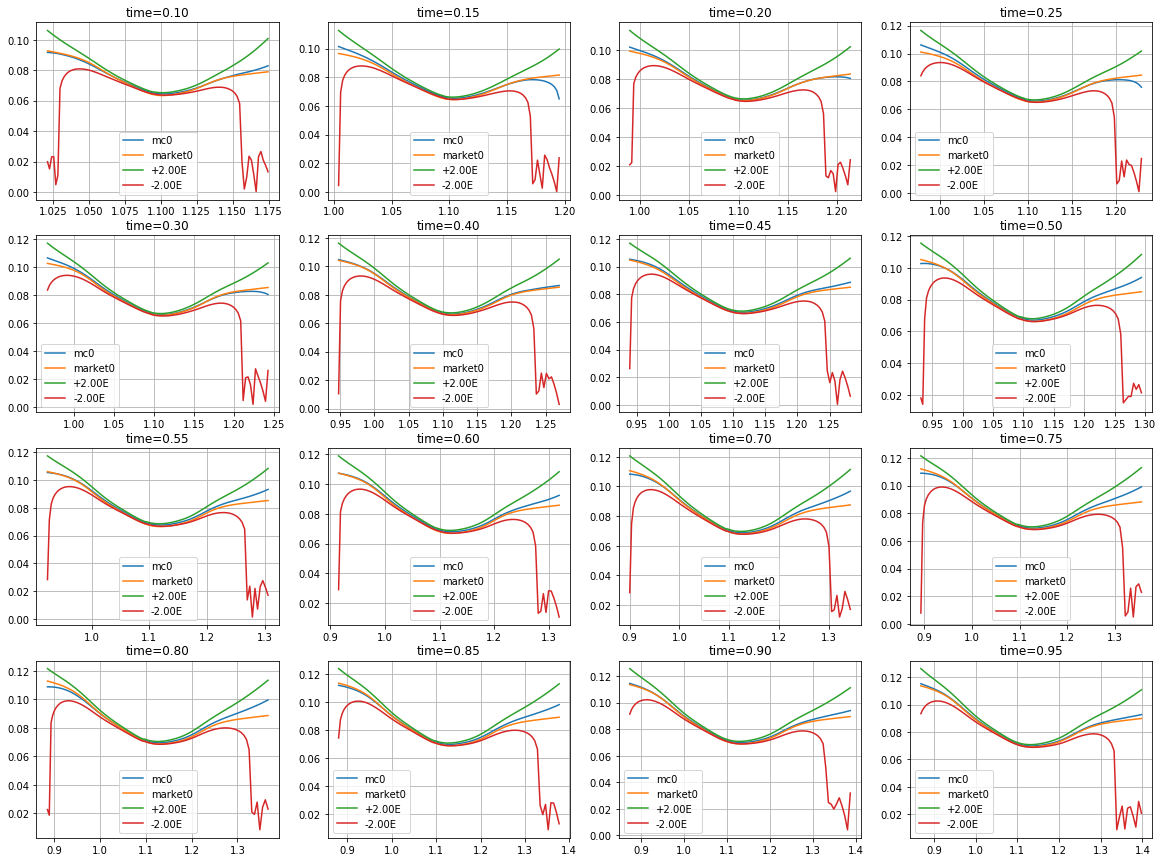

In [27]:
plt.figure(figsize=(20,15))
numplots = 16
till_time = 1.0 #0.5
maxtime = np.minimum(finaldict['Expiry'][-1], till_time)
show_delta = maxtime/numplots
for i1 in range(numplots):
    idxval = np.searchsorted(finaldict['Expiry'], (i1+1)*show_delta)
    ax = plt.subplot(4,4,i1+1)
    ax.plot(finaldict['Strike'][idxval], ivol_mc[idxval], label='mc0')
    ax.plot(finaldict['Strike'][idxval], ivol_market[idxval], label='market0')
    ax.plot(finaldict['Strike'][idxval], ivol_mcup[idxval], label='+%.2fE'%bumpup)
    ax.plot(finaldict['Strike'][idxval], ivol_mcdn[idxval], label='-%.2fE'%bumpdn)
    ax.legend()
    ax.set_title('time=%.2f'%finaldict['Expiry'][idxval])
    ax.grid()